# Project 4 - Advanced Lane Lines

#### Library Import

In [116]:
# Project Libraries
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
import pickle

print('Libraries Imported!')

Libraries Imported!


### Camera Calibration

In [117]:
# Load calibration images
filelist = os.listdir('./camera_cal')
chessboardImages = [cv2.imread('./camera_cal/{}'.format(image)) for image in filelist]

In [118]:
# Find the chessboard corners and undistortion matrix
nx = 9
ny = 6

# create object point
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object and image points for undistortion
objpoints = []
imgpoints = []

for image in chessboardImages:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        

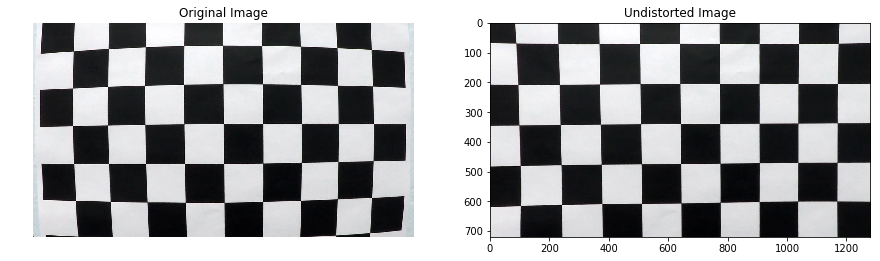

In [119]:
# Use the image and object points to undistort image
test_image = chessboardImages[0]
image_size = (test_image.shape[1], test_image.shape[0])

# Calibrate Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,image_size,None,None)

dst = cv2.undistort(test_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(dst)
ax2.set_title('Undistorted Image')
ax1.axis('off')
plt.show()

In [120]:
# Save matricies to file
pickle.dump(objpoints, open("objpoints.p", "wb"))
pickle.dump(imgpoints, open("imgpoints.p", "wb"))
pickle.dump(mtx, open("cameraMatrix.p", "wb"))
pickle.dump(dist, open("distortionCoeff.p", "wb"))
print('Files saved')


Files saved


In [121]:
# Function to undistort images
def undistort(images):
    imagesUndistort = []
    for image in images:
        image_size = (image.shape[1], image.shape[0])

        # Calibrate Camera
#         ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
#                                                 imgpoints,image_size,None,None)

        imagesUndistort.append(cv2.undistort(image, mtx, dist, None, mtx))
    return np.array(imagesUndistort)

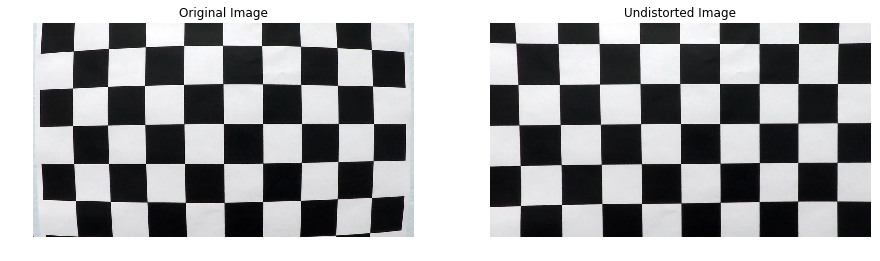

In [128]:
# Test Function
chessboardUndistorted = undistort(chessboardImages)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.imshow(chessboardImages[0])
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(chessboardUndistorted[0])
ax2.set_title('Undistorted Image')
ax2.axis('off')
plt.show()


#### Masking Function from P1

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#vertices = np.array([[(0,imshape[0]),(450, 320), (imshape[1]-450, 320), (imshape[1],imshape[0])]], dtype=np.int32)

In [4]:
# Load matricies to undistort images
mtx = pickle.load(open("cameraMatrix.p", "rb"))
dist = pickle.load(open("distortionCoeff.p", "rb"))
M = pickle.load(open("perspectiveMatrix.p","rb"))
Minv = pickle.load(open("perspectiveMatrixInv.p","rb"))
print("Camera Distortion Matricies Imported")

Camera Distortion Matricies Imported


### Threshold Binary Image

In [5]:
# Function to plot test images
def plotImages(images):
    f, ax = plt.subplots(2,4, figsize=(15,5))
    ax = ax.ravel()
    f.tight_layout()
    for i in range(0,len(images)):
        ax[i].imshow(images[i])
        ax[i].axis('off')
    plt.show()
def plotImagesGray(images):
    f, ax = plt.subplots(2,4, figsize=(15,5))
    ax = ax.ravel()
    f.tight_layout()
    for i in range(0,len(images)):
        ax[i].imshow(images[i], cmap='gray')
        ax[i].axis('off')
    plt.show()

In [124]:
# Load Test Images from file
filelist=[]
for file in os.listdir('./test_images'):
    if file.endswith('.jpg'):
        filelist.append(file)
#         filelist.append('./hardImages/{}'.format(file))
print(filelist)
images = [cv2.imread('./test_images/{}'.format(image)) for image in filelist]

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


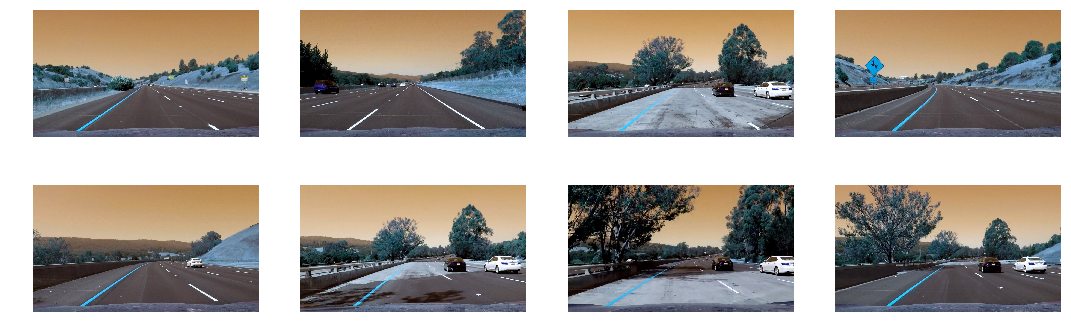

In [125]:
plotImages(images)

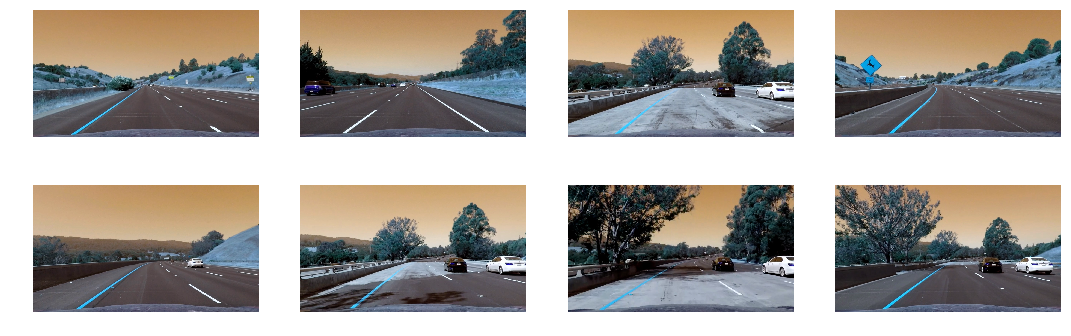

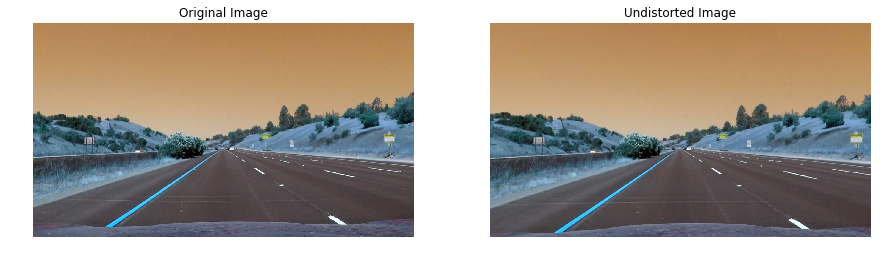

In [129]:
# Undistort Images
imagesUndist = undistort(images)
# imagesUndist = images
plotImages(imagesUndist)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.imshow(images[0])
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(imagesUndist[0])
ax2.set_title('Undistorted Image')
ax2.axis('off')
plt.show()

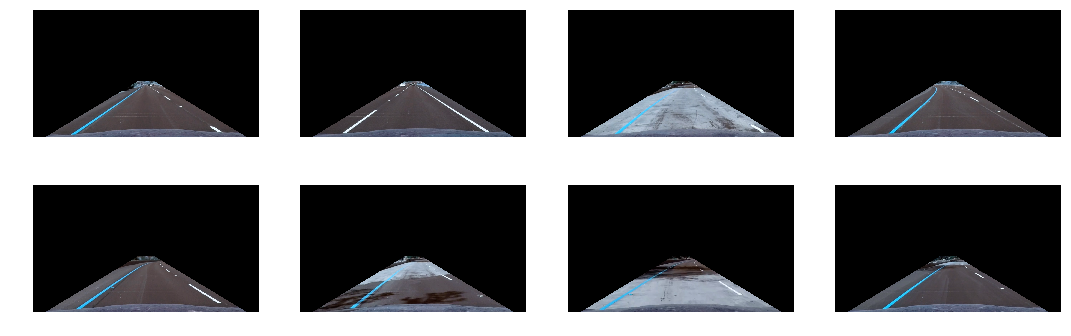

In [130]:
## Mask to region of interest
imshape = imagesUndist[0].shape
x_top=600
x_bottom=70
y=400
vertices = np.array([[(x_bottom,imshape[0]),(x_top, y), (imshape[1]-x_top, y), (imshape[1]-x_bottom,imshape[0])]], dtype=np.int32)

imagesMasked = [region_of_interest(image, vertices) for image in imagesUndist]
plotImages(imagesMasked)

In [133]:
# Convert to various colorspaces to which pick out lines
images_RGB = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imagesUndist])
images_R = images_RGB[:,:,:,0]
images_G = images_RGB[:,:,:,1]
images_B = images_RGB[:,:,:,2]

images_HLS = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2HLS) for img in imagesUndist])
images_H = images_HLS[:,:,:,0]
images_L = images_HLS[:,:,:,1]
images_S = images_HLS[:,:,:,2]

images_HSV = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in imagesUndist])
images_H2 = images_HSV[:,:,:,0]
images_S2 = images_HSV[:,:,:,1]
images_V = images_HSV[:,:,:,2]

images_YUV = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in imagesUndist])
images_Y = images_YUV[:,:,:,0]
images_U = images_YUV[:,:,:,1]
images_V2 = images_YUV[:,:,:,2]

images_LAB = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in imagesUndist])
images_L = images_LAB[:,:,:,0]
images_A = images_LAB[:,:,:,1]
images_B = images_LAB[:,:,:,2]

images_LUV = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2LUV) for img in imagesUndist])
images_L2 = images_LUV[:,:,:,0]
images_U = images_LUV[:,:,:,1]
images_V = images_LUV[:,:,:,2]

images_GRAY = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imagesUndist])

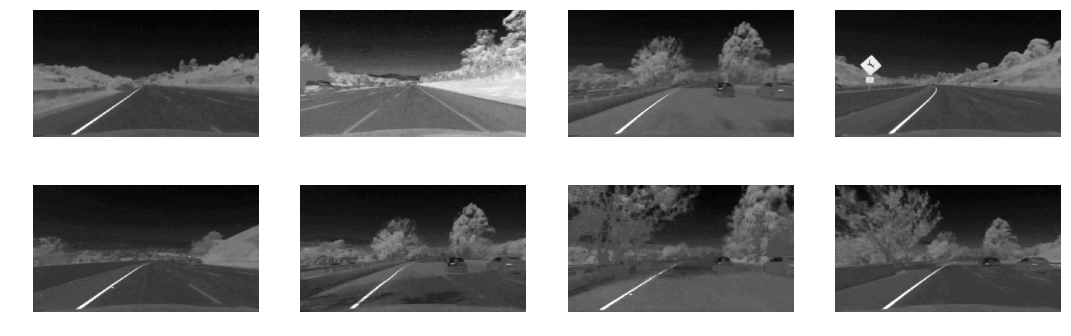

In [134]:
# Plot the colorspace for different colorspaces
plotImagesGray(images_B)

In [135]:
# Apply thresholds to the choosen colorspaces to find the best combination
# R_channel
# H_channel
# S_channel
# V_channel
# V2_channel

def applyThreshold(images, thresh):
    thresholdImages = []
    for image in images:
        binary = np.zeros_like(image)
        binary[(image>thresh[0]) & (image<= thresh[1])] = 1
        thresholdImages.append(binary)
    return np.array(thresholdImages)


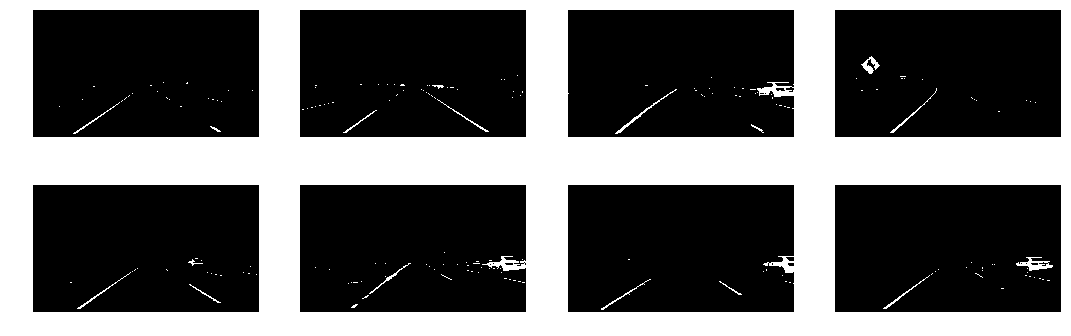

In [136]:
# R_channel
images_Rthresh = applyThreshold(images_R, (220, 255))
plotImagesGray(images_Rthresh)

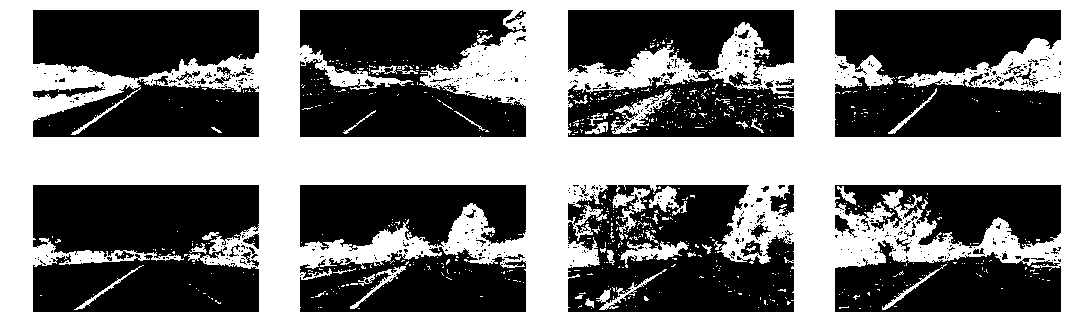

In [137]:
# H_channel
images_Hthresh = applyThreshold(images_H, (15, 100))
plotImagesGray(images_Hthresh)

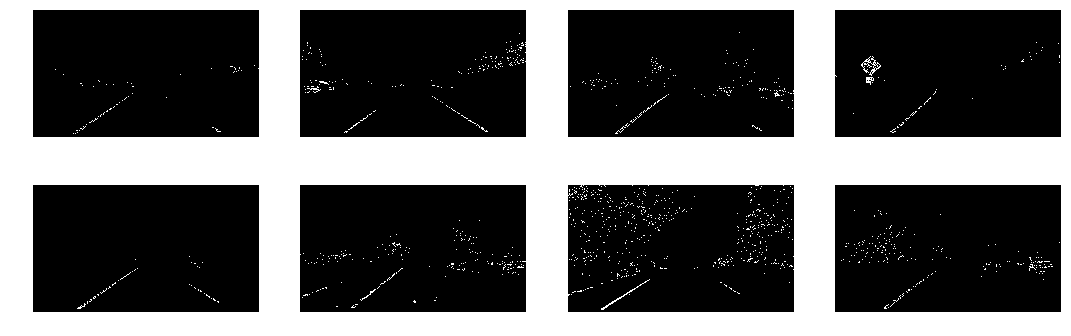

In [138]:
# S_channel
images_Sthresh = applyThreshold(images_S, (170, 250))
plotImagesGray(images_Sthresh)

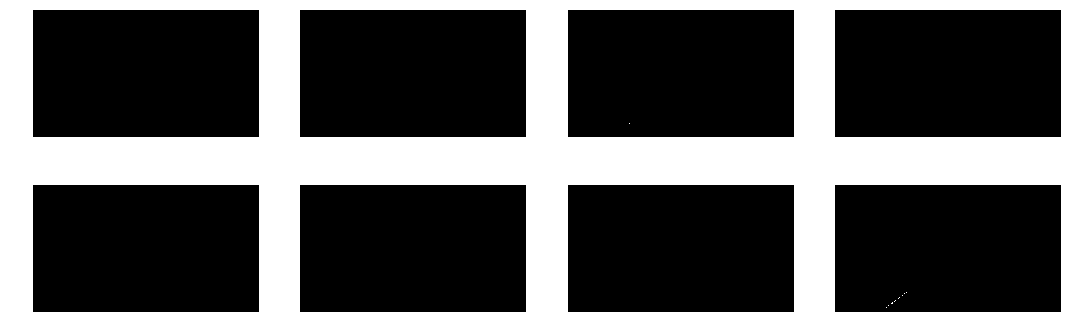

In [139]:
# V_channel
images_Vthresh = applyThreshold(images_V, (220, 250))
plotImagesGray(images_Vthresh)

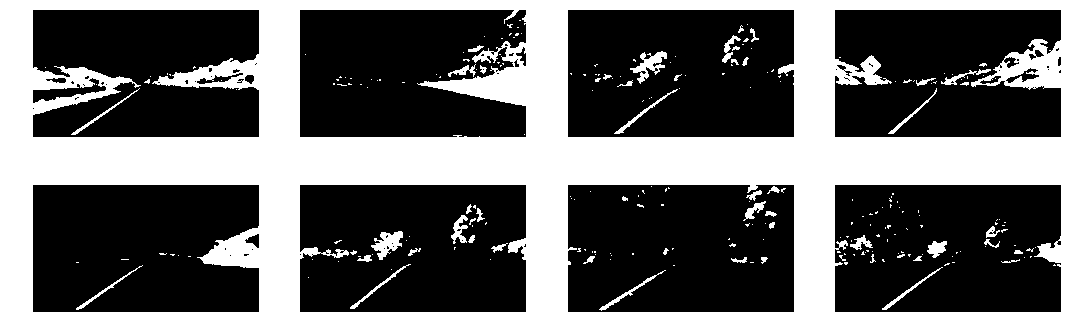

In [140]:
# V2_channel
images_V2thresh = applyThreshold(images_V2, (0, 110))
plotImagesGray(images_V2thresh)

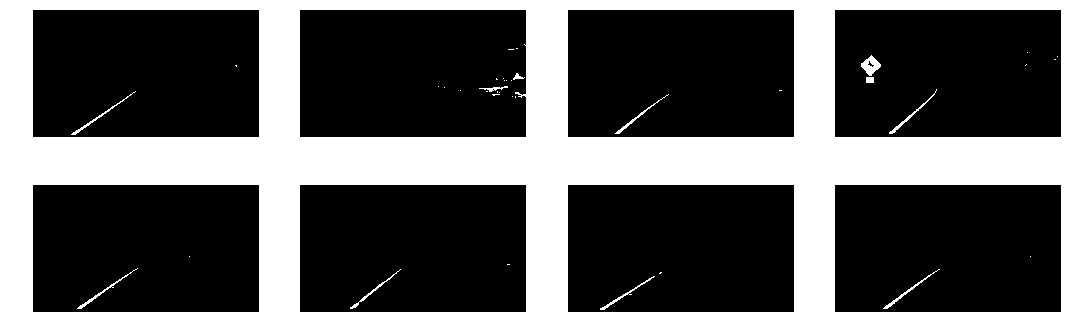

In [141]:
images_Bthresh = applyThreshold(images_B, (160, 255))
plotImagesGray(images_Bthresh)

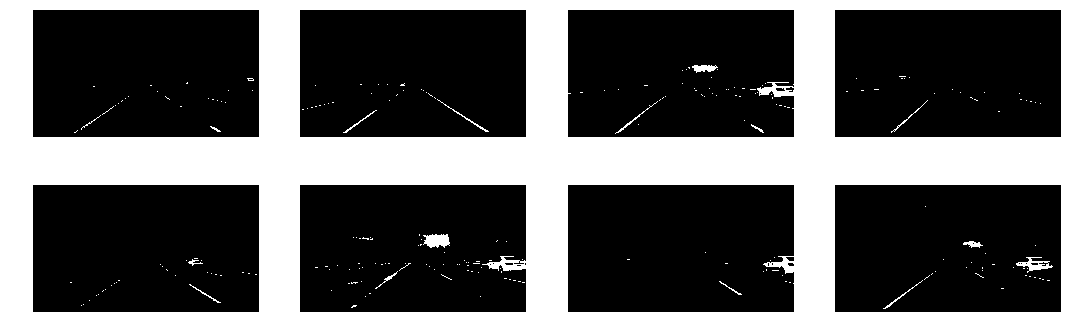

In [142]:
images_L2thresh = applyThreshold(images_L2, (210, 255))
plotImagesGray(images_L2thresh)

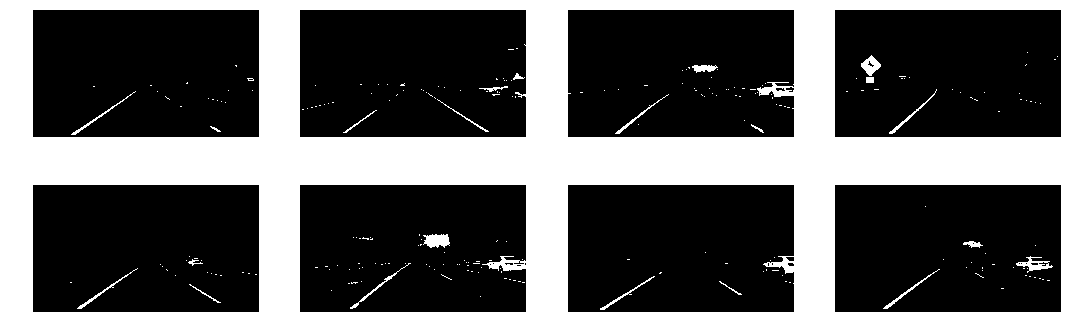

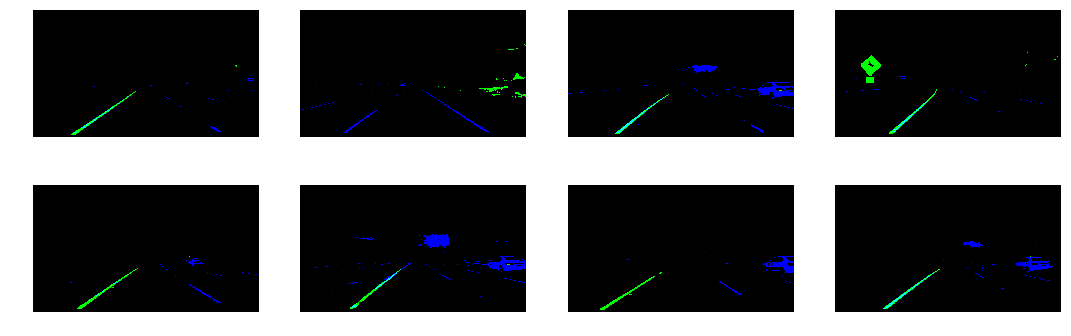

In [143]:
# Combine colorspaces to produce best binary image
binary_thresh = []
binary_thresh_compare = []
for s_image, B_image, L2_image in zip(images_Sthresh, images_Bthresh, images_L2thresh):
#     plt.imshow(s_image)
#     plt.show()
#     plt.imshow(v_image)
#     plt.show()
    binaryCombined = np.zeros_like(s_image)
    binaryCombined[(B_image==1) | (L2_image==1)] = 1 #(s_image==1) | 
    binary_thresh.append(binaryCombined)
    
    stack = np.dstack((np.zeros_like(s_image), B_image*255, L2_image*255)) #np.zeros_like(
    binary_thresh_compare.append(stack)

binary_thresh = np.array(binary_thresh)
binary_thresh_compare = np.array(binary_thresh_compare)
plotImagesGray(binary_thresh)
plotImages(binary_thresh_compare)

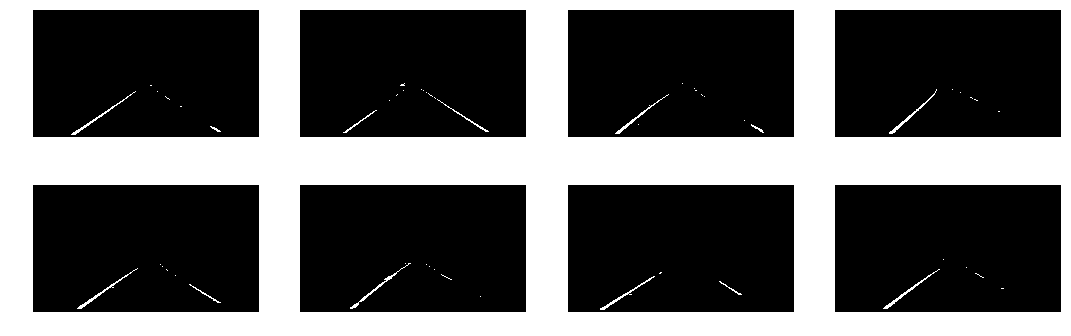

In [144]:
# Function to do the colorspace transforms
def colorspace(images):
    newImages = []
    S = [cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2] for image in images]
    B = [cv2.cvtColor(image, cv2.COLOR_BGR2LAB)[:,:,2] for image in images]
    L = [cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0] for image in images]
    S = applyThreshold(S, (170, 250))
    B = applyThreshold(B, (160, 255))
    L = applyThreshold(L, (210, 255))
    
    for s,b,l in zip(S,B,L):
        binaryCombined = np.zeros_like(s)
        binaryCombined[ (b==1) | (l==1)] = 1 #| (v==1) (s==1) |
        newImages.append(binaryCombined)
        
    return np.array(newImages)

imagesColorspace = colorspace(imagesUndist)
imagesColorspace = np.array(imagesColorspace)
imagesColorspaceMasked = [region_of_interest(image, vertices) for image in imagesColorspace]
plotImagesGray(imagesColorspaceMasked)

### Gradient

In [145]:
def gradient_abs(image, orient='x', sobel_kernel=3, thresh=(0,255)):
    # convert images to grayscale, could try other colorspaces (S, V)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # absolute gradient
    if orient=='x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobelAbs = np.absolute(sobel)
    sobelScaled = np.uint8(255*sobel/np.max(sobelAbs))
    binary_output_abs = np.zeros_like(sobelScaled)
    binary_output_abs[(sobelScaled >= thresh[0]) & (sobelScaled <= thresh[1])] = 1

    
    return binary_output_abs

def gradient_mag(image, sobel_kernel=3, thresh=(0,255)):
    # convert images to grayscale, could try other colorspaces (S, V)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
    
    binary_output_mag = np.zeros_like(gradmag)
    binary_output_mag[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output_mag
    
def gradient_dir(image, sobel_kernel=3, thresh=(0,255)):
    # convert images to grayscale, could try other colorspaces (S, V)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Direction
    sobelAngle = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output_dir = np.zeros_like(sobelAngle)
    binary_output_dir[(sobelAngle >= thresh[0]) & (sobelAngle <= thresh[1])] = 1
    
    return binary_output_dir

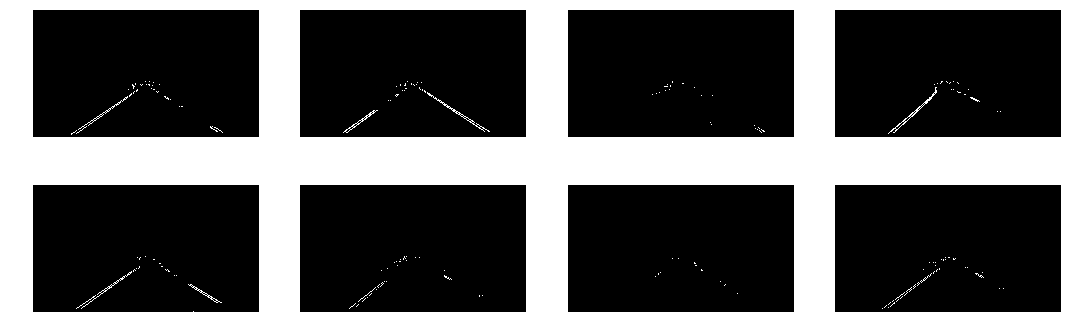

In [146]:
gradientAbsx = []
gradientAbsy = []
gradientMag = []
gradientDir = []
binary_gradient = []
for image in imagesUndist:
    grad_absx = gradient_abs(image, orient='x', sobel_kernel=15, thresh=(55,200))
    grad_absy = gradient_abs(image, orient='y', sobel_kernel=15, thresh=(40,200))
    grad_mag = gradient_mag(image, sobel_kernel=15, thresh=(50,200))
    grad_dir = gradient_dir(image, sobel_kernel=15, thresh=(0.7,1.1))
    gradientAbsx.append(grad_absx)
    gradientAbsy.append(grad_absy)
    gradientMag.append(grad_mag)
    gradientDir.append(grad_dir)
    binary_grad = np.zeros_like(grad_absx)
    binary_grad[((grad_absx==1)&(grad_absy==1)) | ((grad_mag==1)&(grad_dir==1))]=1
    binary_gradient.append(binary_grad)
    
# plotImagesGray(gradientAbsx)
# plotImagesGray(gradientAbsy)
# plotImagesGray(gradientMag)
# plotImagesGray(gradientDir)
# plotImagesGray(binary_gradient)
binary_gradient_mask = [region_of_interest(image, vertices) for image in gradientAbsx]
plotImagesGray(binary_gradient_mask)

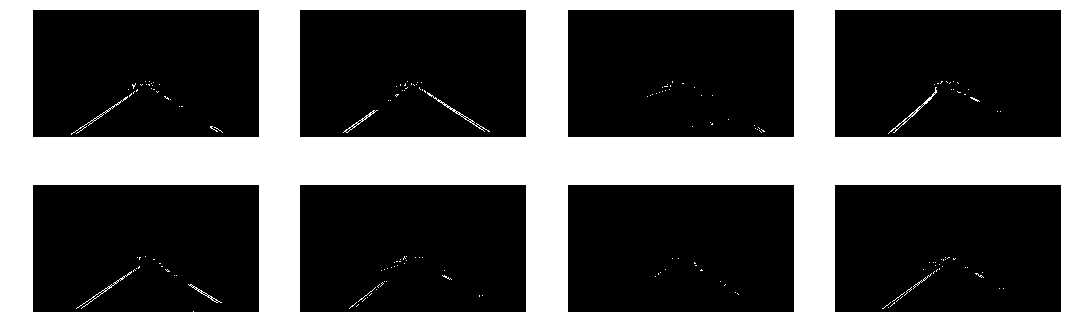

In [147]:
# Function for gradient
def gradient(images):
    newImages = []
    for image in images:
        grad_absx = gradient_abs(image, orient='x', sobel_kernel=15, thresh=(50,200))
        grad_absy = gradient_abs(image, orient='y', sobel_kernel=15, thresh=(20,200))
        grad_mag = gradient_mag(image, sobel_kernel=15, thresh=(40,200))
        grad_dir = gradient_dir(image, sobel_kernel=15, thresh=(0.7,1.1))
        binary_grad = np.zeros_like(grad_absx)
        binary_grad[((grad_absx==1)&(grad_absy==1))]=1 #&((grad_mag==1)) | (grad_dir==1)
        newImages.append(grad_absx)#binary_grad)
    return np.array(newImages)

imagesGradient = gradient(imagesUndist)
imagesGradientMasked = [region_of_interest(image, vertices) for image in imagesGradient]
plotImagesGray(imagesGradientMasked)

### Combine Color and Gradient

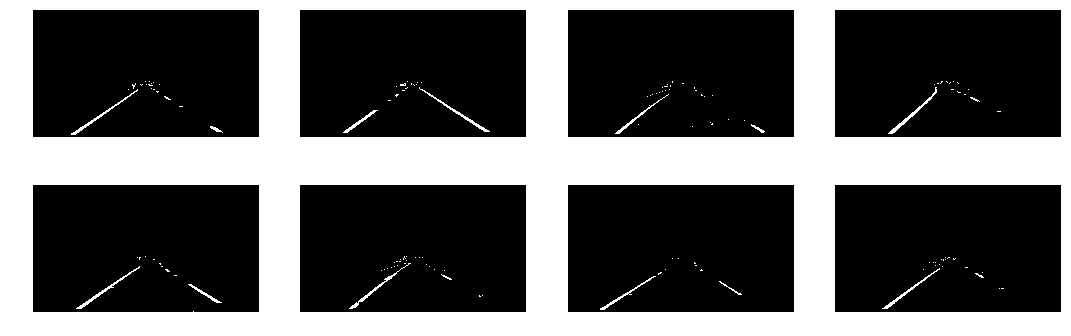

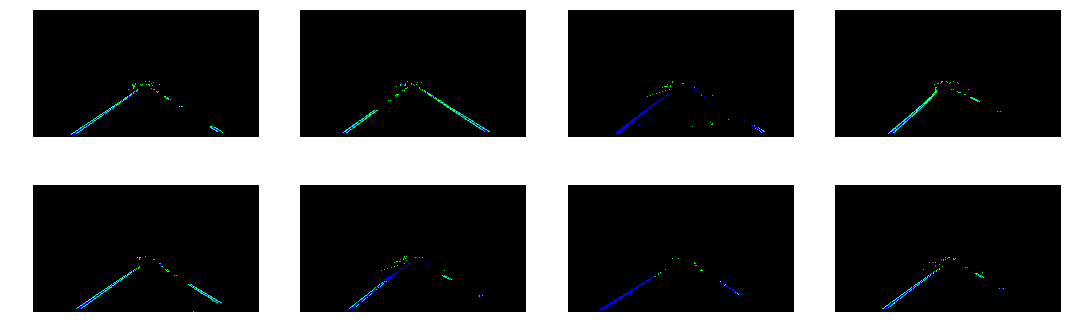

In [148]:
combined_binaries = []
combination_images = []
for g, c in zip(imagesGradientMasked, imagesColorspaceMasked):
    combined_binary = np.zeros_like(g)
    combined_binary[(g==1)|(c==1)] = 1#(g==1)|
    combination_image = np.dstack((np.zeros_like(g), g*255, c*255))
    combined_binaries.append(combined_binary)
    combination_images.append(combination_image)
    
plotImagesGray(combined_binaries)
plotImagesGray(combination_images)

### Perspective Transform

720


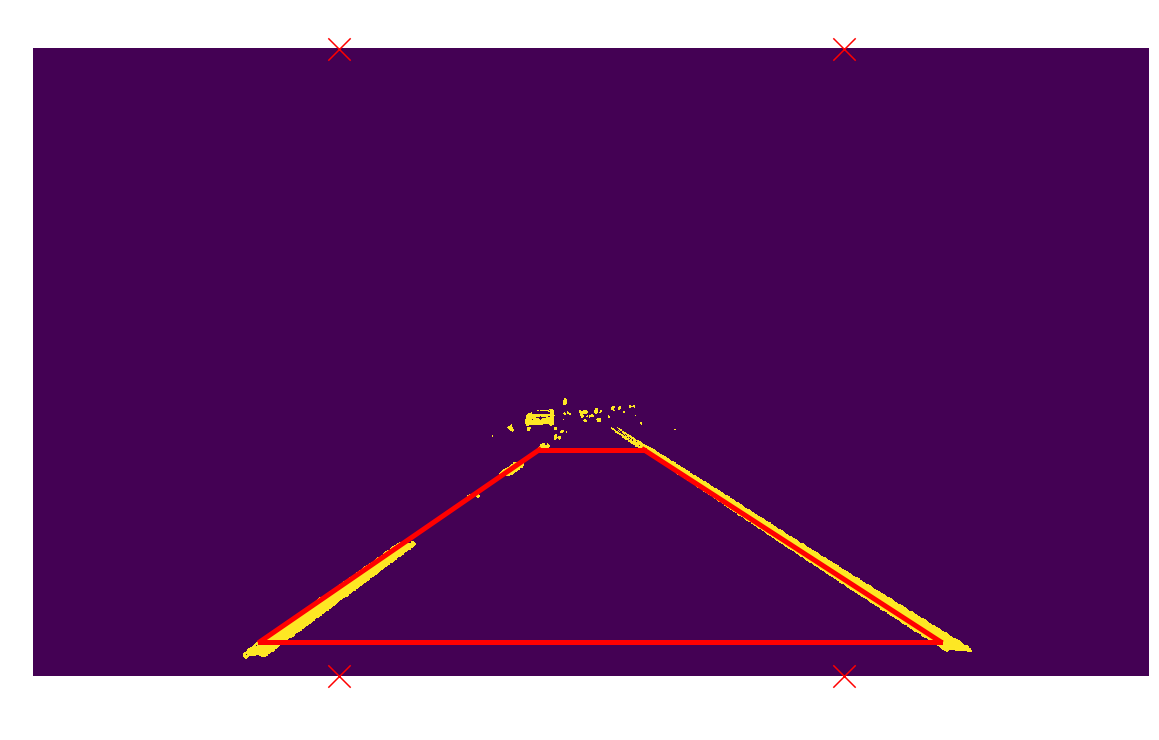

In [160]:
# Get Perspective Matrix
src = np.float32([[580, 460], [700,460], [1040,imshape[0]-40], [260, imshape[0]-40]])
dst = np.float32([[350,0], [930,0], [930,imshape[0]], [350, imshape[0]]])

print(imshape[0])
plt.figure(figsize=(20,20))
plt.imshow(combined_binaries[1])
# plt.scatter(src[0,0], src[0,1], marker='x', c='r', s=100)
# plt.scatter(src[1,0], src[1,1], marker='x', c='g', s=100)
# plt.scatter(src[2,0], src[2,1], marker='x', c='b', s=100)
# plt.scatter(src[3,0], src[3,1], marker='x', c='y', s=100)
plt.plot([src[0,0],src[1,0]], [src[0,1],src[1,1]], c='r', lw=5)
plt.plot([src[1,0],src[2,0]], [src[1,1],src[2,1]], c='r', lw=5)
plt.plot([src[2,0],src[3,0]], [src[2,1],src[3,1]], c='r', lw=5)
plt.plot([src[3,0],src[0,0]], [src[3,1],src[0,1]], c='r', lw=5)
plt.scatter(dst[0,0], dst[0,1], marker='x', c='r', s=500)
plt.scatter(dst[1,0], dst[1,1], marker='x', c='r', s=500)
plt.scatter(dst[2,0], dst[2,1], marker='x', c='r', s=500)
plt.scatter(dst[3,0], dst[3,1], marker='x', c='r', s=500)
plt.axis('off')
plt.show()


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Save M to file
pickle.dump(M, open("perspectiveMatrix.p", "wb"))
pickle.dump(Minv, open("perspectiveMatrixInv.p", "wb"))


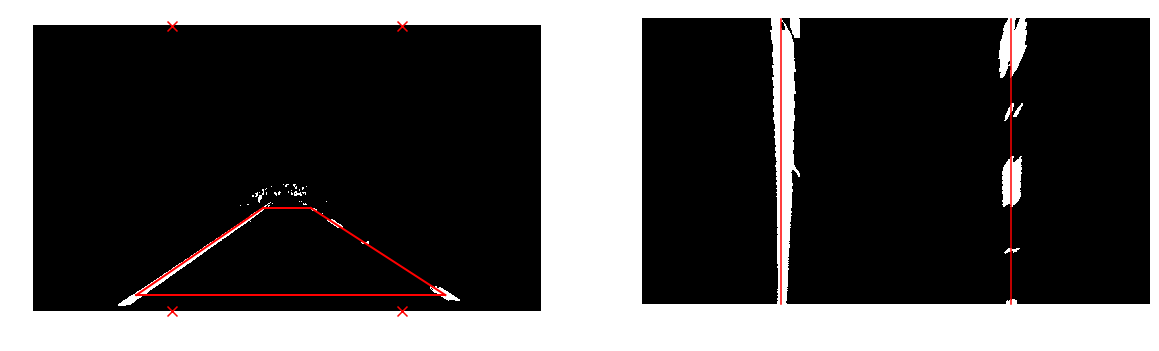

In [173]:
warped_images = [cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR) 
                     for image in imagesUndist]
warped_binaries = [cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
                       for image in combined_binaries]
f, ax = plt.subplots(1,2, figsize=(20,20))
ax = ax.ravel()
# f.tight_layout()
for i in range(0,len(ax),2):
#     ax[i].imshow(imagesUndist[int(i/4)])
#     ax[i].axis('off')
#     ax[i+1].imshow(warped_images[int(i/4)])
#     ax[i+1].axis('off')
#     ax[i+1].plot([dst[0,0], dst[3,0]], [dst[0,1], dst[3,1]], c='r')
#     ax[i+1].plot([dst[1,0], dst[2,0]], [dst[1,1], dst[2,1]], c='r')
    ax[i].imshow(combined_binaries[int(i/4)], cmap='gray')
    ax[i].plot([src[0,0],src[1,0]], [src[0,1],src[1,1]], c='r', lw=2)
    ax[i].plot([src[1,0],src[2,0]], [src[1,1],src[2,1]], c='r', lw=2)
    ax[i].plot([src[2,0],src[3,0]], [src[2,1],src[3,1]], c='r', lw=2)
    ax[i].plot([src[3,0],src[0,0]], [src[3,1],src[0,1]], c='r', lw=2)
    ax[i].scatter(dst[0,0], dst[0,1], marker='x', c='r', s=100)
    ax[i].scatter(dst[1,0], dst[1,1], marker='x', c='r', s=100)
    ax[i].scatter(dst[2,0], dst[2,1], marker='x', c='r', s=100)
    ax[i].scatter(dst[3,0], dst[3,1], marker='x', c='r', s=100)
    ax[i].axis('off')
    
    ax[i+1].imshow(warped_binaries[int(i/4)], cmap='gray')
    ax[i+1].axis('off')
    ax[i+1].plot([dst[0,0], dst[3,0]], [dst[0,1], dst[3,1]], c='r')
    ax[i+1].plot([dst[1,0], dst[2,0]], [dst[1,1], dst[2,1]], c='r')
plt.show()



# plt.imshow(warped, cmap='gray')
# plt.plot([dst[0,0], dst[3,0]], [dst[0,1], dst[3,1]], c='r')
# plt.plot([dst[1,0], dst[2,0]], [dst[1,1], dst[2,1]], c='r')
# plt.show()

### Find Lane Curve

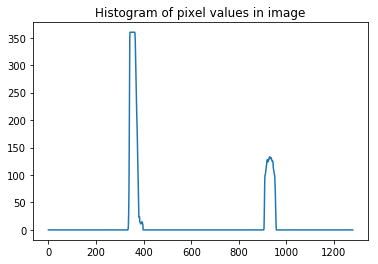

In [175]:
testImage = warped_binaries[0]
histogram = np.sum(testImage[imshape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title('Histogram of pixel values in image')
plt.show()

In [176]:
def fitLine(x, y, order):
    # Fit line
    coeffs = np.polyfit(x,y,order)
    
    # Calc R squared
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y-ybar)**2)
    rsquared = 1-(ssreg/sstot)
    
    return coeffs, rsquared

In [177]:
def radiusOfCurvature(x,y):
    ymperpix = 30/720
    xmperpix = 3.7/580
    
    # Refit using meter
    coeffs = np.polyfit(y*ymperpix, x*xmperpix, 2)
    
    yeval = np.max(y)*ymperpix
    # Calc radius of curvature
    Rcurve = ((1 + (2*coeffs[0]*yeval + coeffs[1])**2)**1.5) / (2*coeffs[0])
    basePos = coeffs[0]*yeval**2 + coeffs[1]*yeval + coeffs[2]
    
    yeval = np.min(y)*ymperpix
    topPos = coeffs[0]*yeval**2 + coeffs[1]*yeval + coeffs[2]
    
    return Rcurve, basePos, topPos

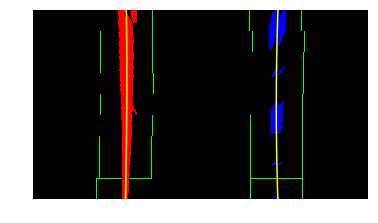

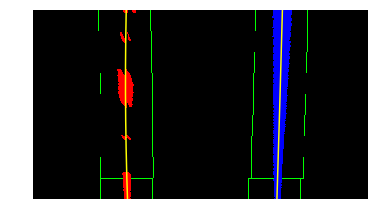

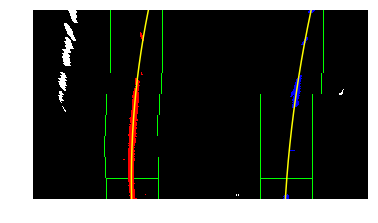

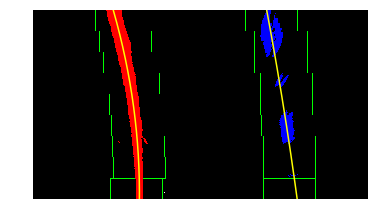

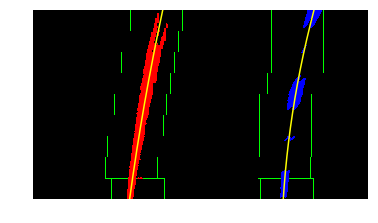

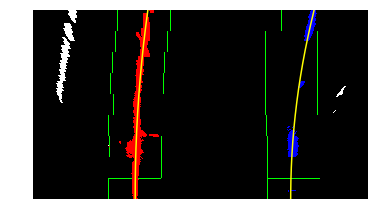

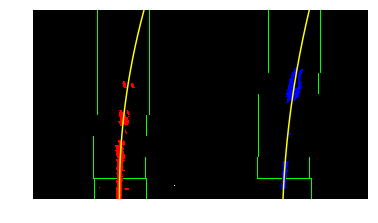

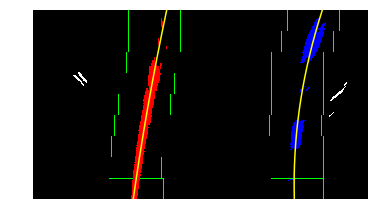

In [180]:
for image in warped_binaries:
    histogram = np.sum(image[imshape[0]//2:,:], axis=0)
    outImg = np.dstack((image, image, image))*255
    # Get the left and right lane bases
    midpoint = np.int(histogram.shape[0]/2)
    leftlaneBase = np.argmax(histogram[:midpoint])
    rightlaneBase = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set up windows to analyse with
    nwindows = 9
    windowHeight = np.int(imshape[0]/nwindows)
    windowWidth = 100
    
    # Get non zero pixels in image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Start Position
    left_current = leftlaneBase
    right_current = rightlaneBase
    
    # Number of pixels to recenter window
    minpix = 500
    
    # Lists for indicies
    leftLane_idx = []
    rightLane_idx = []
    
    # Step through each window
    for window in range(nwindows):
        # Bounderies
        winY_low = imshape[0] - (window+1)*windowHeight
        winY_high = imshape[0] - window*windowHeight
        winXL_low = left_current - windowWidth
        winXL_high = left_current + windowWidth
        winXR_low = right_current - windowWidth
        winXR_high = right_current + windowWidth
        
        # Draw windows on image
        cv2.rectangle(outImg, (winXL_low, winY_low), (winXL_high, winY_high), (0,255,0), 2)
        cv2.rectangle(outImg, (winXR_low, winY_low), (winXR_high, winY_high), (0,255,0), 2)
        
        # Pixels wihtin the window
        goodIdx_left = ((nonzeroy>=winY_low) & (nonzeroy<winY_high) & (nonzerox>=winXL_low) & (nonzerox<winXL_high)).nonzero()[0]
        goodIdx_right = ((nonzeroy>=winY_low) & (nonzeroy<winY_high) & (nonzerox>=winXR_low) & (nonzerox<winXR_high)).nonzero()[0]
        leftLane_idx.append(goodIdx_left)
        rightLane_idx.append(goodIdx_right)
        
        # Shift windows
        if len(goodIdx_left) > minpix:
            left_current = np.int(np.mean(nonzerox[goodIdx_left]))
        if len(goodIdx_right) > minpix:
            right_current = np.int(np.mean(nonzerox[goodIdx_right]))
 
    leftLane_idx = np.concatenate(leftLane_idx)
    rightLane_idx = np.concatenate(rightLane_idx)
    
    #extract pixels for polyfit
    leftx = nonzerox[leftLane_idx]
    lefty = nonzeroy[leftLane_idx]
    rightx = nonzerox[rightLane_idx]
    righty = nonzeroy[rightLane_idx]
    
#     left_fit, L_rSquared, _, _, _ = np.polyfit(lefty, leftx, 2, full=True)
#     right_fit, R_rSquared, _, _, _ = np.polyfit(righty, rightx, 2, full=True)
    left_fit, rSquared_L = fitLine(lefty, leftx, 2)
    right_fit, rSquared_R = fitLine(righty, rightx, 2)
    
    ploty = np.linspace(0, imshape[0]-1, imshape[0])
    left_RCurve, leftBase, leftTop = radiusOfCurvature(leftx, lefty)
    right_RCurve, rightBase, rightTop = radiusOfCurvature(rightx, righty)
    
    distBase = rightBase - leftBase
    distTop = rightTop - leftTop
    
    # plot the line on the images
    left_lane = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_lane  = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     left_lane, right_lane, ploty, _, _ = findLanesLocal(image, left_fit, right_fit)
    
    
    outImg[nonzeroy[leftLane_idx], nonzerox[leftLane_idx]] = [255, 0 ,0]
    outImg[nonzeroy[rightLane_idx], nonzerox[rightLane_idx]] = [0, 0 ,255]
    plt.imshow(outImg)
    plt.plot(left_lane, ploty, color='yellow')
    plt.plot(right_lane, ploty, color='yellow')
#     plt.title('Left Curve: {:.5} | Right Curve: {:.5} | Rad Diff: {:.7} | distBase: {:.2} | distTop: {:.2} | diff: {:.2}'
#               .format(left_RCurve, right_RCurve, abs(abs(left_RCurve)-abs(right_RCurve)) / max(abs(left_RCurve), abs(right_RCurve)), distBase, distTop, abs(distBase-distTop)))
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.axis('off')
    plt.show()

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

left_RCurve = radiusOfCurvature(leftx, ploty)
right_RCurve = radiusOfCurvature(rightx, ploty)

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.title('Left Curve: {} | Right Curve: {}'.format(left_RCurve, right_RCurve))
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [ ]:
dd = cv2.imread('./test_images/warped-example1.jpg')
plt.imshow(dd)
plt.show()
dd = undistort([dd])
c = colorspace(dd)
plt.imshow(c[0], cmap='gray')
plt.show()
g = gradient(dd)
plt.imshow(g[0], cmap='gray')
plt.show()
combined_binary = np.zeros_like(g)
combined_binary[(g==1)|(c==1)] = 1
plt.imshow(combined_binary[0], cmap='gray')
plt.show()
warped = cv2.warpPerspective(combined_binary[0], M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray')
plt.show()
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()